# Library import

In [39]:


import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import random


from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

# Get and Setting Data 

In [40]:
# Parameter for data
## Security code
#stock_code = code1
## Start Date
start_date = '2000-1-1'
interval = "1wk"
## End Date
#end_date = '2022-12-31'
## Split ratio of train data and validation data
train_rate = 0.75
## How many business days to see
observation_period_num=8
## How many business days to predict
predict_period_num=8

# Parameter for mdoel
## Learning Rate
lr=0.00001
## Epoch Number
epochs=64
## Mini-Batch size
batch_size=16
## How many epochs to stop train if valid loss is not decreasing
patience=16

device = torch.device("mps" )






In [41]:
code1=pd.read_csv("nikkei1.csv",header=0)["コード"].to_list()
code2=pd.read_csv("nikkei2.csv",header=0)["コード"].to_list()
df1=wb.DataReader(code1, start=start_date, interval=interval)
df2=wb.DataReader(code2, start=start_date, interval=interval)
df=pd.concat([df1["Adj Close"].reset_index(drop=True), df2["Adj Close"].reset_index(drop=True),df1["Volume"].reset_index(drop=True), df2["Volume"].reset_index(drop=True)], axis=1)
df

[*********************100%***********************]  39 of 39 completed
[*********************100%***********************]  10 of 10 completed


,1812.T,2432.T,2502.T,3289.T,4188.T,4502.T,4751.T,4755.T,5020.T,5108.T,...,CL,DX-Y.NYB,USDJPY=X,^DJI,^FVX,^GSPC,^IXIC,^SOX,^TNX,^VIX
0,356.944672,NaN,761.385376,NaN,512.216980,2770.919922,NaN,NaN,NaN,1671.883911,...,19335000.0,0.0,0.0,9.128100e+08,0.0,5.343800e+09,7.990830e+09,0.0,0.0,0.0
1,384.774231,NaN,769.729431,NaN,574.807068,2911.896240,NaN,NaN,NaN,1473.307373,...,16571800.0,0.0,0.0,9.812800e+08,0.0,5.169700e+09,8.045670e+09,0.0,0.0,0.0
2,370.254517,NaN,754.432129,NaN,535.209290,2868.145020,NaN,NaN,NaN,1534.161987,...,12096400.0,0.0,0.0,7.903800e+08,0.0,4.455000e+09,7.012420e+09,0.0,0.0,0.0
3,356.944672,NaN,730.095642,NaN,526.267700,2795.225830,NaN,NaN,NaN,1441.279297,...,11535400.0,0.0,0.0,9.781800e+08,0.0,5.532100e+09,8.864510e+09,0.0,0.0,0.0
4,341.214935,NaN,711.321716,NaN,560.756226,2955.647461,NaN,NaN,NaN,1559.784790,...,20279400.0,0.0,0.0,8.843800e+08,0.0,5.205000e+09,7.907530e+09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,1659.000000,1787.0,4866.000000,665.0,804.500000,4348.000000,1129.0,653.0,475.899994,5378.000000,...,20954400.0,0.0,0.0,1.584990e+09,0.0,2.142239e+10,2.674696e+10,0.0,0.0,0.0
1210,1571.000000,1763.0,4740.000000,643.0,760.099976,4380.000000,1134.0,628.0,454.500000,5066.000000,...,30403900.0,0.0,0.0,2.394800e+09,0.0,3.386797e+10,3.104905e+10,0.0,0.0,0.0
1211,1567.000000,1780.0,4770.000000,621.0,765.000000,4271.000000,1142.0,634.0,461.000000,5165.000000,...,15794000.0,0.0,0.0,1.381820e+09,0.0,1.979199e+10,1.969955e+10,0.0,0.0,0.0
1212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3494058.0,NaN,NaN,3.354301e+08,0.0,2.797479e+09,4.208773e+09,0.0,0.0,0.0


In [75]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df=df.fillna(0)
df

np.savetxt("unnormalize", [std_list, mean_list], delimiter =", ")


In [68]:
# Array initialization
in_data=[]
in_label=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
    data=df.iloc[i:i+observation_period_num,:].values
    in_data.append(data)
    label=df.iloc[i+observation_period_num:i+observation_period_num+predict_period_num,:].values
    in_label.append(label)
in_data=torch.FloatTensor(in_data).to(device)
in_label=torch.FloatTensor(in_label).to(device)

class DataSet:
    def __init__(self):
        self.X = in_data # 入力
        self.t = in_label # 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

dataset = DataSet()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*train_rate), len(dataset)-int(len(dataset)*train_rate)])
test_data=dataset[-1]
print(test_data)
obsv=torch.FloatTensor(df.iloc[-observation_period_num:,:].values).to(device)
obsv=torch.unsqueeze(obsv, dim=0)
#print(obsv)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



print('data：',len(dataset))
print('train：',len(train_dataset))
print('valid：',len(val_dataset))


(tensor([[ 1.6707e+00,  1.5068e-01,  1.3714e+00,  8.7338e-01,  1.1167e+00,
          1.2860e+00,  1.1641e+00, -4.3491e-01,  5.2948e-01,  1.9853e+00,
          1.4308e+00,  1.6502e-01,  1.6283e-01,  2.9816e+00,  1.9993e+00,
          7.6738e-01,  2.3217e+00,  1.0945e+00,  3.5682e-01,  3.1944e+00,
          9.7962e-01, -6.0983e-01,  6.3533e-01,  3.1629e+00,  2.7911e+00,
          1.0648e-01,  1.4605e+00, -8.4763e-01,  2.0762e+00,  2.2097e+00,
          1.6458e+00,  1.6944e+00,  9.8191e-01,  1.2367e+00, -1.7936e+00,
         -1.7852e+00,  2.2408e+00, -1.4489e-01,  1.9488e+00,  1.7018e+00,
          1.1485e+00,  2.1709e+00,  2.0962e+00,  6.7601e-01,  1.9845e+00,
          1.6763e+00,  2.0332e+00,  2.0772e-01,  3.0547e-01, -7.4517e-01,
         -1.3126e-01, -6.2225e-01, -3.5228e-01, -2.8218e-01,  1.2377e+00,
         -5.4351e-01,  9.0641e-01,  1.1798e+00, -9.0981e-01, -2.2199e-01,
          9.9824e-01, -4.2279e-01, -5.3974e-01, -7.0258e-01,  2.4004e+00,
         -1.0568e+00, -5.4330e-01, -8

# Model Definition

In [44]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)
  
  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [45]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=98,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("mps")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=7,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size, feature_size)
  
  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [46]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf
        
    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score:
            self.counter+=1
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

# Train

torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 8, 98])
torch.Size([16, 

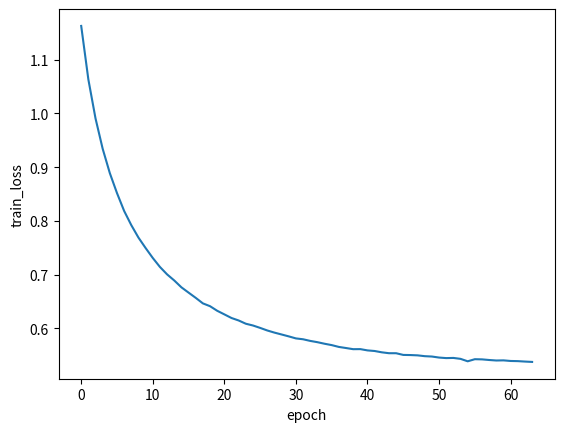

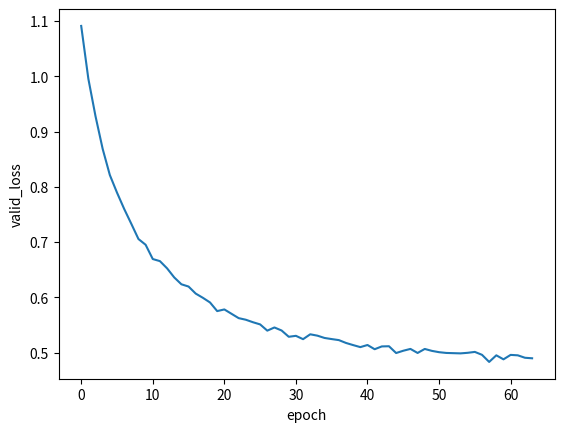

In [47]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  
  model.train()
  total_loss_train=0.0
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  for x in train_dataloader:
    data=x[0]
    print(np.shape(data))
    targets=x[1]
    print(np.shape(targets))    
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_dataloader)

  #valid
  model.eval()
  total_loss_valid=0.0
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  for y in val_dataloader:
    data=y[0]
    targets=y[1]
    output=model(data)
    total_loss_valid+=criterion(output, targets).item()
  total_loss_valid=total_loss_valid/len(val_dataloader)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

# Test

In [76]:
torch.save(model, "stockpredict.pth")
unnorm=np.loadtxt("unnormalize")
std_list=unnorm[0]
mean_list=unnorm[1]
print(std_list, mean_list)

ValueError: could not convert string '1.000000000000000000e+00,' to float64 at row 0, column 1.

(1, 8, 98)


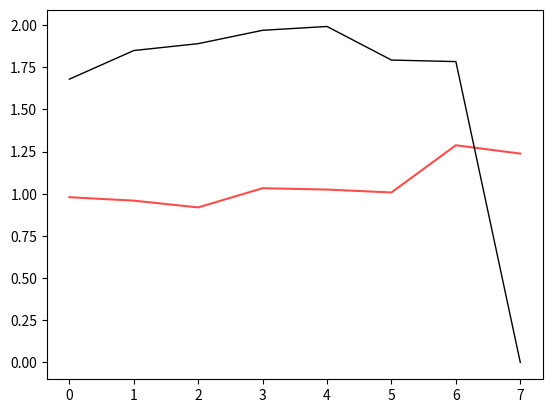

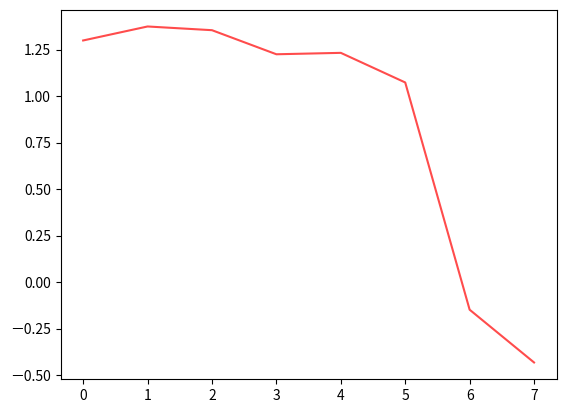

In [73]:
model.eval()
result=model(torch.unsqueeze(test_data[0], dim=0))
actual=test_data[1]
result=result.to('cpu').detach().numpy().copy()
actual=actual.to('cpu').detach().numpy().copy()
print(np.shape(result))
plt.plot([x[0] for x in result[0]],color='red',alpha=0.7)
plt.plot([y[0] for y in actual],color='black',linewidth=1.0)
plt.show()

predict=model(obsv)
predict=predict.to('cpu').detach().numpy().copy()
plt.plot([z[0] for z in predict[0]],color='red',alpha=0.7)
